In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

import warnings
warnings.filterwarnings("ignore")

C:\Users\sidde\Downloads\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the dataset :

In [2]:
target_df = pd.read_csv('1_target_ts.csv')
target_df.head()

,item,org,date,quantity
0,3959294,1617388,2014-03-01,6375.0
1,3959294,1617388,2014-04-01,6797.0
2,3959294,1617388,2014-05-01,7091.0
3,3959294,1617388,2014-06-01,7499.0
4,3959294,1617388,2014-07-01,7603.0


In [3]:
target_df.tail()

,item,org,date,quantity
9486,149440644,42023714,2020-10-01,1577.0
9487,149440644,42023714,2020-11-01,1127.0
9488,149440644,42023714,2020-12-01,1613.0
9489,149440644,42023714,2021-01-01,1591.0
9490,149440644,42023714,2021-02-01,968.0


In [4]:
target_df = target_df.rename(columns = {'date': 'Date', 'quantity' : 'Quantity'})
target_df.head()

,item,org,Date,Quantity
0,3959294,1617388,2014-03-01,6375.0
1,3959294,1617388,2014-04-01,6797.0
2,3959294,1617388,2014-05-01,7091.0
3,3959294,1617388,2014-06-01,7499.0
4,3959294,1617388,2014-07-01,7603.0


## Data Information : 

In [5]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9491 entries, 0 to 9490
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item      9491 non-null   int64  
 1   org       9491 non-null   int64  
 2   Date      9491 non-null   object 
 3   Quantity  9491 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 296.7+ KB


## Data Description :

In [6]:
target_df.describe()

,item,org,Quantity
count,9.491000e+03,9.491000e+03,9491.000000
mean,7.634510e+07,2.132429e+07,7117.596671
std,5.105328e+07,1.971765e+07,18632.107772
min,3.959294e+06,1.617388e+06,0.000000
25%,6.609938e+06,1.618308e+06,920.000000
50%,1.032641e+08,4.002264e+07,2577.000000
75%,1.168448e+08,4.202371e+07,5599.500000
max,1.494406e+08,4.202371e+07,632612.000000


In [7]:
#Extracting year and month from Date column
target_df['Date'] = pd.to_datetime(target_df['Date'], format = '%Y/%m/%d')

In [8]:
target_df['Year'] = target_df['Date'].dt.year
target_df['Month'] = target_df['Date'].dt.month

In [9]:
target_df.head()

,item,org,Date,Quantity,Year,Month
0,3959294,1617388,2014-03-01,6375.0,2014,3
1,3959294,1617388,2014-04-01,6797.0,2014,4
2,3959294,1617388,2014-05-01,7091.0,2014,5
3,3959294,1617388,2014-06-01,7499.0,2014,6
4,3959294,1617388,2014-07-01,7603.0,2014,7


In [10]:
#Dropping item and org column
target_df.drop(columns = ['item', 'org'], axis = 1, inplace = True)

In [11]:
target_df.head()

,Date,Quantity,Year,Month
0,2014-03-01,6375.0,2014,3
1,2014-04-01,6797.0,2014,4
2,2014-05-01,7091.0,2014,5
3,2014-06-01,7499.0,2014,6
4,2014-07-01,7603.0,2014,7


## Exploratory Data Analysis :

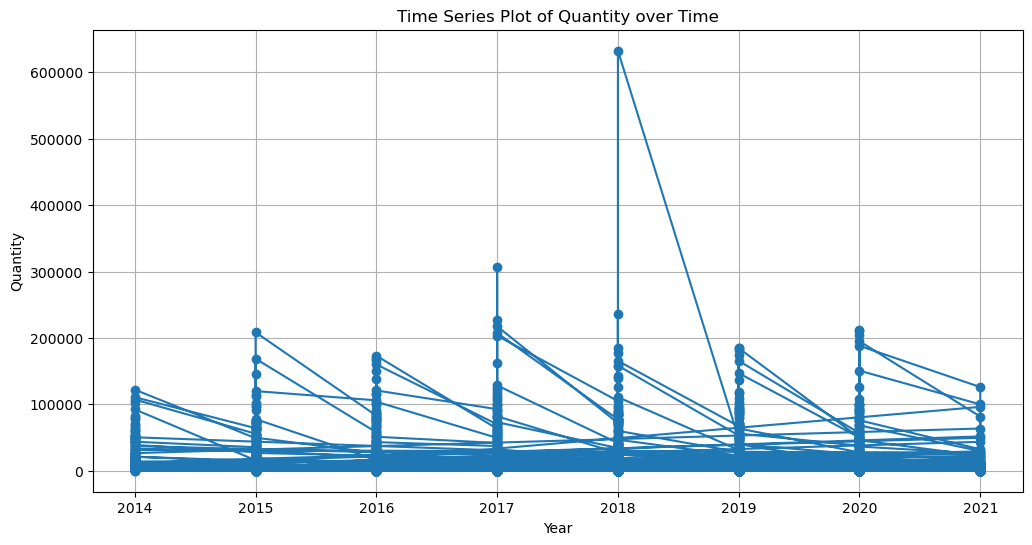

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(target_df['Year'], target_df['Quantity'], marker='o')
plt.title('Time Series Plot of Quantity over Time')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

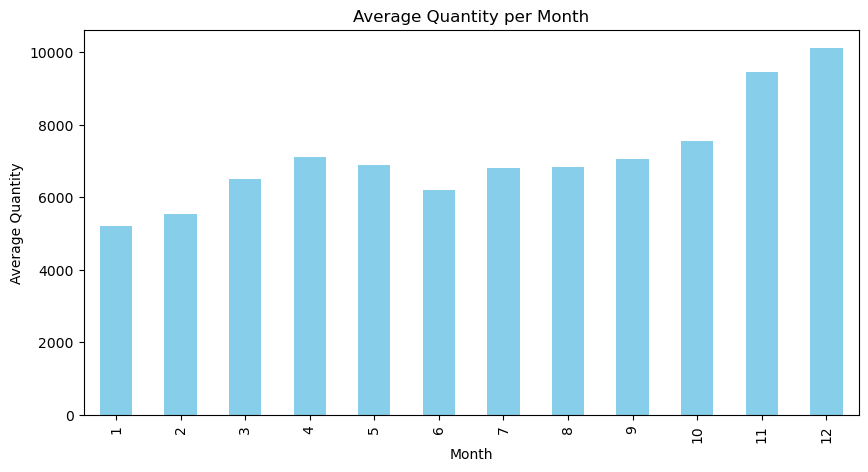

In [13]:
monthly_avg = target_df.groupby('Month')['Quantity'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Quantity per Month')
plt.xlabel('Month')
plt.ylabel('Average Quantity')
plt.show()

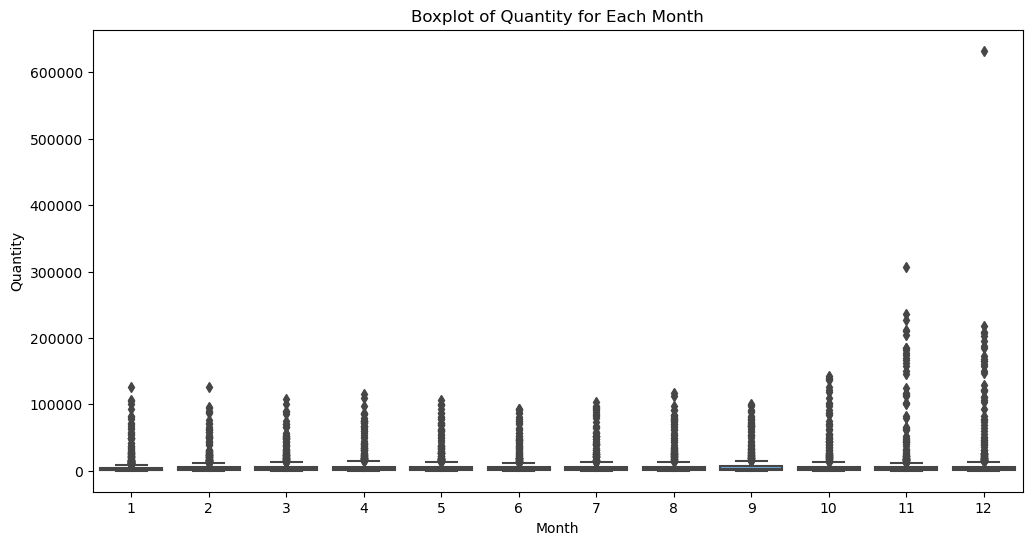

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Quantity', data = target_df)
plt.title('Boxplot of Quantity for Each Month')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.show()

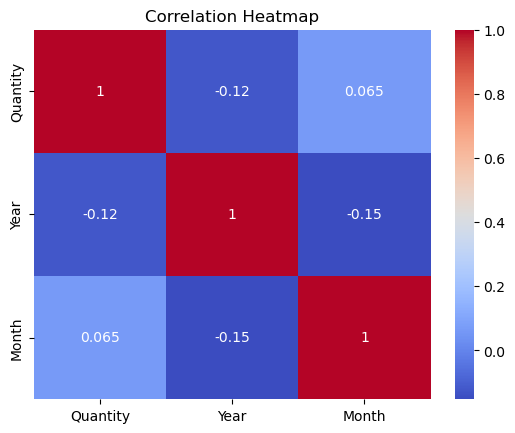

In [15]:
correlation_matrix = target_df[['Quantity', 'Year', 'Month']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Checking for Stationarity :

In [16]:
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(target_df['Quantity'], autolag = 'AIC')

print("1. ADF : ", df_test[0])
print("2. P-Value :", df_test[1])
print("3. Num of lags", df_test[2])
print("4. Number of Obwervations Used for ADF Regression and Critical Values Calculation :", df_test[3])
print("5. Critical Values :")
for key, val in df_test[4].items():
    print("\t", key, " : ", val)

1. ADF :  -7.174395011283103
2. P-Value : 2.7512697665146224e-10
3. Num of lags 36
4. Number of Obwervations Used for ADF Regression and Critical Values Calculation : 9454
5. Critical Values :
	 1%  :  -3.431041884539187
	 5%  :  -2.8618457698646864
	 10%  :  -2.566932756200858


### ACF & PACF :

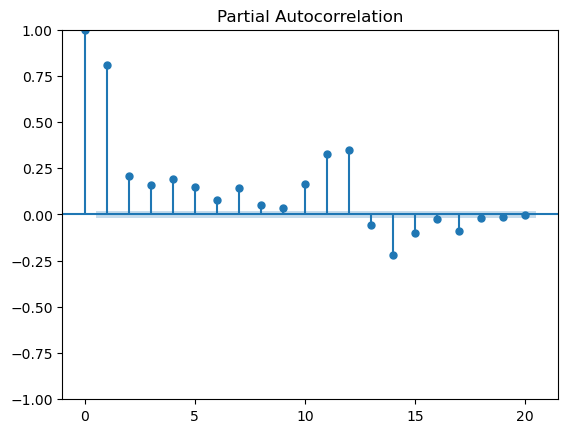

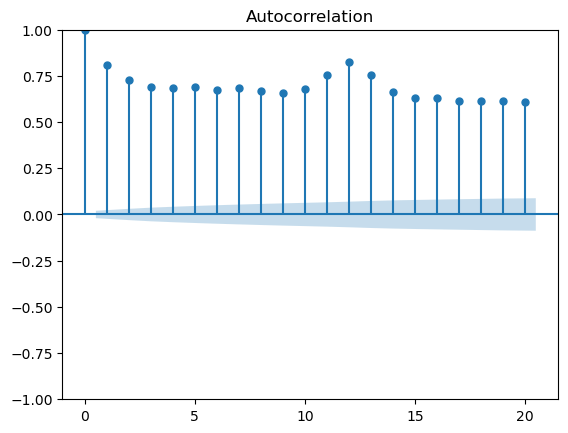

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(target_df['Quantity'], lags = 20)
acf = plot_acf(target_df['Quantity'], lags = 20)

In [18]:
#dropping the year and month columns
target_df.drop(columns = ['Year', 'Month'], axis = 1, inplace = True)

In [19]:
 # changing index to datetime
target_df.set_index(['Date'], inplace=  True)
target_df.head()

,Quantity
Date,
2014-03-01,6375.0
2014-04-01,6797.0
2014-05-01,7091.0
2014-06-01,7499.0
2014-07-01,7603.0


### Resampling Data to Month Wise :

In [20]:
target_df = target_df.resample('M').sum()

In [21]:
# Calculate the index for the split point
split_index = int(len(target_df) * 0.8)

# Split the data into train and test sets
Train = target_df.iloc[:split_index]
Test = target_df.iloc[split_index:]

In [22]:
print(Train.shape)
print(Test.shape)

(67, 1)
(17, 1)


**Below is the function used for calculating mape**

In [23]:
def Mape(y_true, y_pred):
    """ Mean Absolute Percentage Error """
    
    # convert to numpy arrays
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # take the percentage error
    pe = (y_true - y_pred) / y_true
    
    # take the absolute values
    ape = np.abs(pe)
    
    # quantify the performance in a single number
    mape = np.mean(ape)
    
    return f'{mape*100:.2f}%'

## Auto Regression :

In [24]:
from statsmodels.tsa.ar_model import AutoReg
model =  AutoReg(Train, lags = 6).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:               Quantity   No. Observations:                   67
Model:                     AutoReg(6)   Log Likelihood                -831.560
Method:               Conditional MLE   S.D. of innovations         201429.028
Date:                Mon, 13 Nov 2023   AIC                           1679.120
Time:                        22:45:30   BIC                           1696.007
Sample:                    09-30-2014   HQIC                          1685.738
                         - 09-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.405e+05   7.98e+04      1.760      0.078   -1.59e+04    2.97e+05
Quantity.L1     0.6156      0.128      4.808      0.000       0.365       0.867
Quantity.L2    -0.1165      0.150     -0.777    

In [25]:
# Make predictions on the test set
pred = model.predict(start=len(Train), end=len(Train)+len(Test)-1, dynamic=False)
print(pred)

2019-10-31    1.030580e+06
2019-11-30    1.008091e+06
2019-12-31    1.021638e+06
2020-01-31    1.019700e+06
2020-02-29    1.012188e+06
2020-03-31    9.955211e+05
2020-04-30    9.867899e+05
2020-05-31    9.848024e+05
2020-06-30    9.820852e+05
2020-07-31    9.760930e+05
2020-08-31    9.688891e+05
2020-09-30    9.638008e+05
2020-10-31    9.606447e+05
2020-11-30    9.575406e+05
2020-12-31    9.536632e+05
2021-01-31    9.496849e+05
2021-02-28    9.464121e+05
Freq: M, dtype: float64


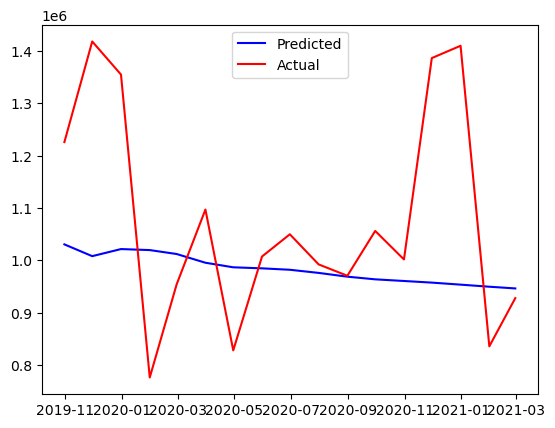

In [26]:
from matplotlib import pyplot
pyplot.plot(pred, color='blue', label='Predicted')
pyplot.plot(Test, color='red', label='Actual')
pyplot.legend()
pyplot.show()

AutoReg Model Evaluation:
MAE: 162400.12569589008
MAPE: 14.35%


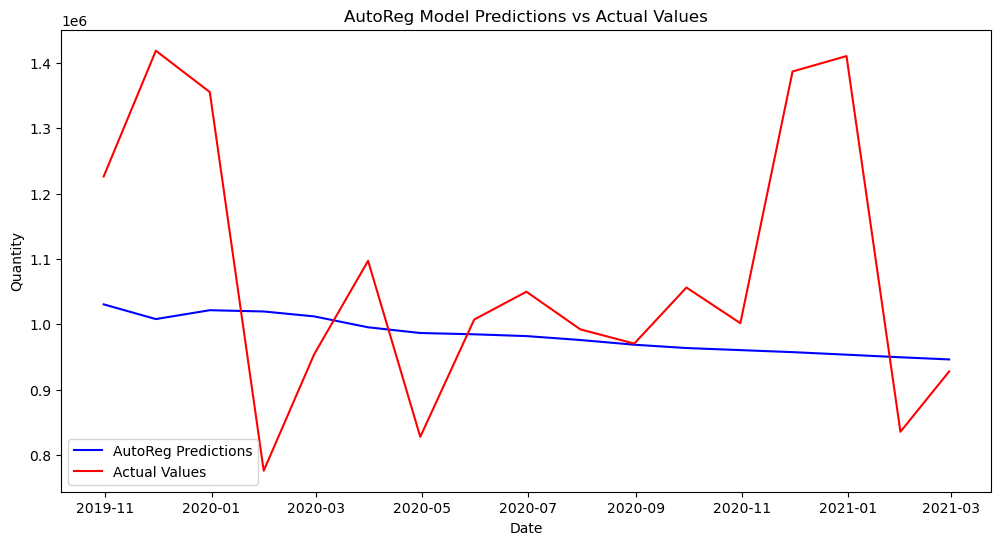

In [27]:
# Evaluate and plot the results
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate metrics
rmse_ar = np.sqrt(mean_squared_error(Test, pred))
mae_ar = mean_absolute_error(Test, pred)
mape_ar = Mape(y_true=Test, y_pred=pred)

print(f'AutoReg Model Evaluation:')
print(f'MAE: {mae_ar}')
print(f'MAPE: {mape_ar}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target_df.index[-len(Test):], pred, label='AutoReg Predictions', color='blue')
plt.plot(target_df.index[-len(Test):], Test, label='Actual Values', color='red')
plt.title('AutoReg Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [28]:
mape_ar = Mape(y_true=Test, y_pred= pred)
print(f'Our Auto Regression Model has a mean absolute percentage error of {mape_ar}')

Our Auto Regression Model has a mean absolute percentage error of 14.35%


## Simple Exponential Smoothing :

In [29]:
# create the model
model = SimpleExpSmoothing(Train.Quantity)

# fit the model
model_fit = model.fit()

# make predictions for the test set
preds = model_fit.predict(len(Test.Quantity))


In [30]:
print(preds)

Date
2015-08-31    4.629830e+05
2015-09-30    4.676523e+05
2015-10-31    4.662153e+05
2015-11-30    4.789501e+05
2015-12-31    5.587666e+05
2016-01-31    6.497647e+05
2016-02-29    5.945058e+05
2016-03-31    5.605848e+05
2016-04-30    5.241836e+05
2016-05-31    5.449204e+05
2016-06-30    5.698318e+05
2016-07-31    5.597846e+05
2016-08-31    5.415577e+05
2016-09-30    5.507257e+05
2016-10-31    5.645784e+05
2016-11-30    6.137570e+05
2016-12-31    7.205286e+05
2017-01-31    8.010379e+05
2017-02-28    7.294019e+05
2017-03-31    6.731049e+05
2017-04-30    6.626447e+05
2017-05-31    6.963762e+05
2017-06-30    6.973184e+05
2017-07-31    6.711319e+05
2017-08-31    6.723719e+05
2017-09-30    7.092779e+05
2017-10-31    7.684228e+05
2017-11-30    8.226562e+05
2017-12-31    1.000628e+06
2018-01-31    1.148537e+06
2018-02-28    1.049339e+06
2018-03-31    9.772487e+05
2018-04-30    9.448743e+05
2018-05-31    9.357475e+05
2018-06-30    9.339248e+05
2018-07-31    9.022631e+05
2018-08-31    9.127219e

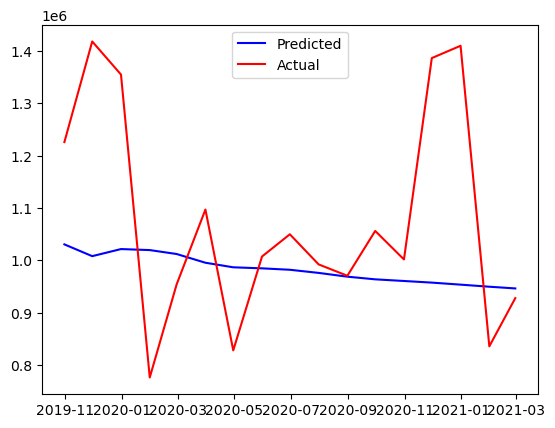

In [31]:
from matplotlib import pyplot
pyplot.plot(pred, color='blue', label='Predicted')
pyplot.plot(Test, color='red', label='Actual')
pyplot.legend()
pyplot.show()

In [32]:
mape_ses1 = Mape(y_true=Test, y_pred= preds)
print(f'Our Simple Exponential Smoothing Model has a mean absolute percentage error of {mape_ses1}')

Our Simple Exponential Smoothing Model has a mean absolute percentage error of 29.92%


## ARIMA :

In [33]:
from pmdarima import auto_arima

In [34]:
model_2 = auto_arima(target_df['Quantity'], trace = True, suppress_warnings = True)
model_2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2274.990, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2289.883, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2290.131, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2279.161, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2287.985, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2273.189, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2274.618, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2278.169, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2279.541, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2271.276, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2279.988, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2272.865, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2276.765, Time=0.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1131.011
Date:                Mon, 13 Nov 2023   AIC                           2270.022
Time:                        22:45:48   BIC                           2279.697
Sample:                    03-31-2014   HQIC                          2273.909
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3934      0.268      1.466      0.143      -0.133       0.919
ar.L2         -0.2807      0.209     -1.345      0.179      -0.690       0.128
ma.L1         -0.7857      0.223     -3.526      0.000      -1.222      -0.349
sigma2      4.438e+10   1.47e-12   3.02e+22      0.000    4.44e+10    4.44e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                28.61
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               4.57   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.16e+38. Standard errors may be unstable.
"""

In [35]:
# Make predictions on the testing set
preds = model_2.predict(len(Test))

In [36]:
mape_arm = Mape(y_true=Test.values, y_pred=preds)

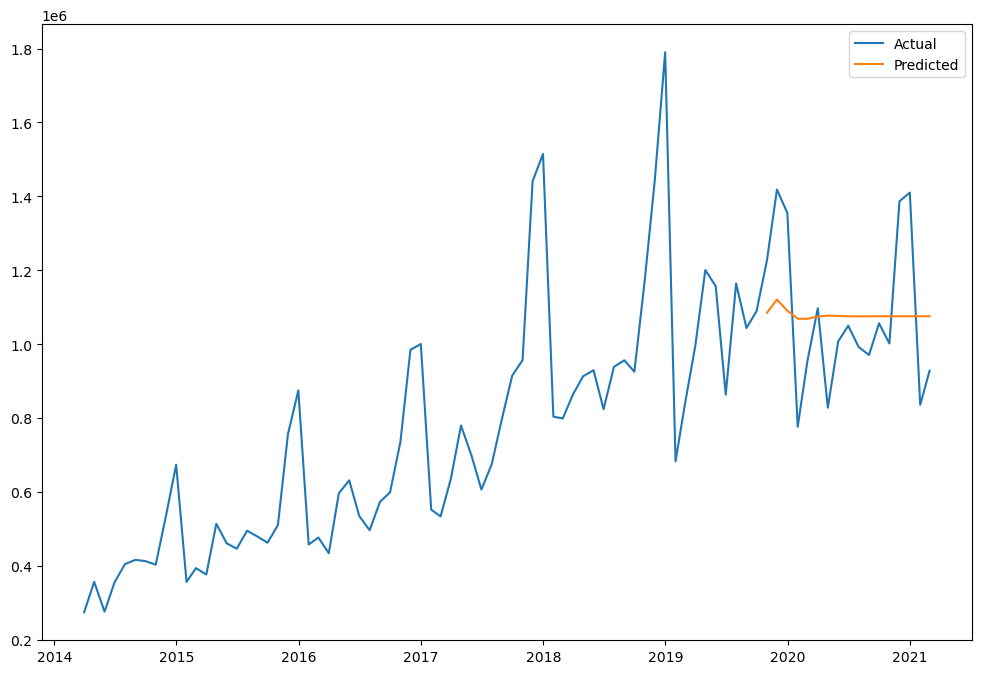

In [37]:
# Set the figure size
plt.figure(figsize=(12, 8))
# Plot the actual vs predicted values
plt.plot(target_df.index, target_df['Quantity'], label='Actual')
plt.plot(Test.index, preds, label='Predicted')
plt.legend()
plt.show()

In [38]:
print(f'Our ARIMA model has a mean absolute percentage error of {mape_arm}')

Our ARIMA model has a mean absolute percentage error of 15.95%


In [39]:
# Best Parameters ARIMA
model = ARIMA(Train, order = (2,1,1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                   67
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -898.986
Date:                Mon, 13 Nov 2023   AIC                           1805.973
Time:                        22:45:57   BIC                           1814.731
Sample:                    03-31-2014   HQIC                          1809.434
                         - 09-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4151      0.327      1.269      0.204      -0.226       1.056
ar.L2         -0.2586      0.251     -1.032      0.302      -0.750       0.233
ma.L1         -0.7737      0.289     -2.676      0.0

In [40]:
# Make predictions on the testing set
preds_ar = res.forecast(len(Test))

In [41]:
mape_arm1 = Mape(y_true=Test.values, y_pred=preds_ar)

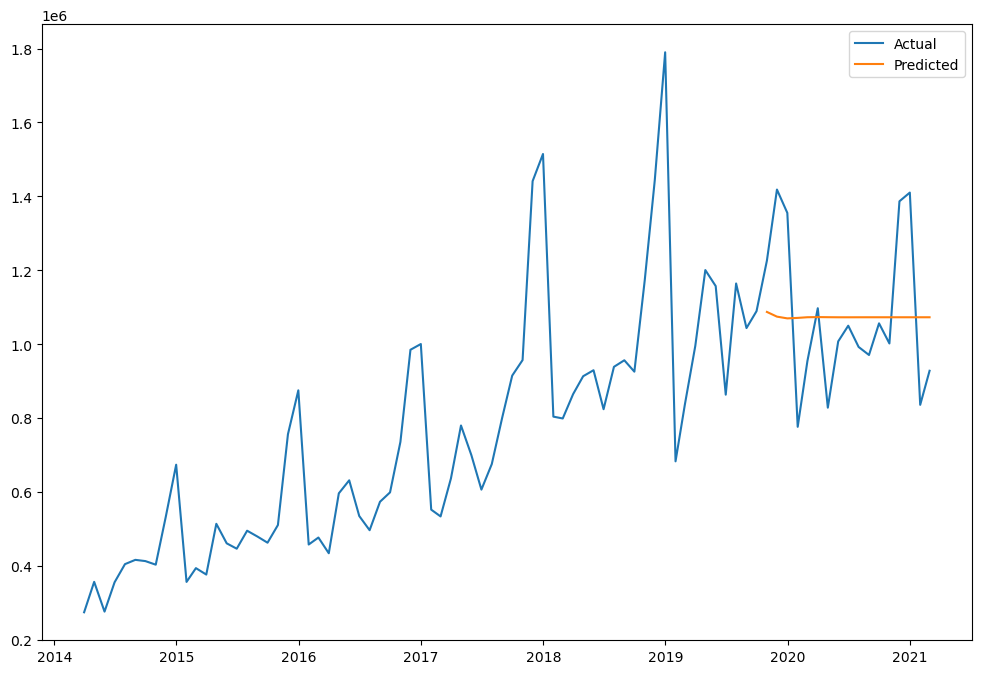

In [42]:
# Set the figure size
plt.figure(figsize=(12, 8))
# Plot the actual vs predicted values
plt.plot(target_df.index, target_df['Quantity'], label='Actual')
plt.plot(Test.index, preds_ar, label='Predicted')
plt.legend()
plt.show()

In [43]:
print(f'Our ARIMA model has a mean absolute percentage error of {mape_arm1}')

Our ARIMA model has a mean absolute percentage error of 15.71%


# Holts Winter Exponential Smoothing with additive seasonality and additive trend (Holt-Winters Additive Method) :

In [44]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Quantity"], seasonal = "add", trend = "add", seasonal_periods = 6).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0], end = Test.index[-1])


In [45]:
print(pred_hwe_add_add)

2019-10-31    1.104521e+06
2019-11-30    1.199632e+06
2019-12-31    1.245330e+06
2020-01-31    1.088587e+06
2020-02-29    1.099976e+06
2020-03-31    1.079732e+06
2020-04-30    1.169301e+06
2020-05-31    1.264412e+06
2020-06-30    1.310110e+06
2020-07-31    1.153367e+06
2020-08-31    1.164756e+06
2020-09-30    1.144512e+06
2020-10-31    1.234082e+06
2020-11-30    1.329192e+06
2020-12-31    1.374890e+06
2021-01-31    1.218148e+06
2021-02-28    1.229536e+06
Freq: M, dtype: float64


In [46]:
mape_hwe_add_add = Mape(y_true=Test.values, y_pred=pred_hwe_add_add)

In [47]:
print(f'Our Holts winter exponential smoothing with additive seasonality and additive trend method has a mean absolute percentage error of {mape_hwe_add_add}')

Our Holts winter exponential smoothing with additive seasonality and additive trend method has a mean absolute percentage error of 22.42%


# Holts winter exponential smoothing with multiplicative seasonality and additive trend :

In [48]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Quantity"], seasonal = "mul", trend = "add", seasonal_periods = 3).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0], end = Test.index[-1])

In [49]:
print(pred_hwe_mul_add)

2019-10-31    1.144410e+06
2019-11-30    1.125167e+06
2019-12-31    1.228258e+06
2020-01-31    1.179461e+06
2020-02-29    1.159280e+06
2020-03-31    1.265124e+06
2020-04-30    1.214512e+06
2020-05-31    1.193393e+06
2020-06-30    1.301990e+06
2020-07-31    1.249563e+06
2020-08-31    1.227506e+06
2020-09-30    1.338857e+06
2020-10-31    1.284613e+06
2020-11-30    1.261619e+06
2020-12-31    1.375723e+06
2021-01-31    1.319664e+06
2021-02-28    1.295732e+06
Freq: M, dtype: float64


In [50]:
mape_hwe_mul_add = Mape(y_true=Test.values, y_pred=pred_hwe_mul_add)

In [51]:
print(f'Our Holts winter exponential smoothing with multiplicative seasonality and additive trend method has a mean absolute percentage error of {mape_hwe_mul_add}')

Our Holts winter exponential smoothing with multiplicative seasonality and additive trend method has a mean absolute percentage error of 24.89%


# Holts winter exponential smoothing with multiplicative seasonality ,additive trend and Rolling Mean :

In [52]:
window_size = 15
rolling_mean = Test['Quantity'].rolling(window_size).mean().fillna(method='bfill')

# Use rolling mean values to calculate MAPE
mape_rm = np.mean(np.abs(rolling_mean - Test['Quantity']) / Test['Quantity']) * 100

# Fit HWE model on training data
hwe_model_mul_add_rm = ExponentialSmoothing(Train["Quantity"], seasonal = "mul", trend = "add", seasonal_periods = 10).fit()

# Predict demand for rolling mean test data
pred_hwe_rm = hwe_model_mul_add_rm.predict(start = Test.index[0], end = Test.index[-1])

# Calculate MAPE for HWE with rolling mean test data
mape_hwe_rm = np.mean(np.abs(rolling_mean - pred_hwe_rm) / rolling_mean) * 100
print(mape_hwe_rm)

7.4352665274181255


In [53]:
mape_hwe_rm_add = Mape(y_true=Test.values, y_pred=pred_hwe_rm)
print(mape_hwe_rm)

7.4352665274181255


In [54]:
print(f'Our Holts winter exponential smoothing with multiplicative seasonality, additive trend and Rolling mean has  mean absolute percentage error of {mape_hwe_rm}%')

Our Holts winter exponential smoothing with multiplicative seasonality, additive trend and Rolling mean has  mean absolute percentage error of 7.4352665274181255%


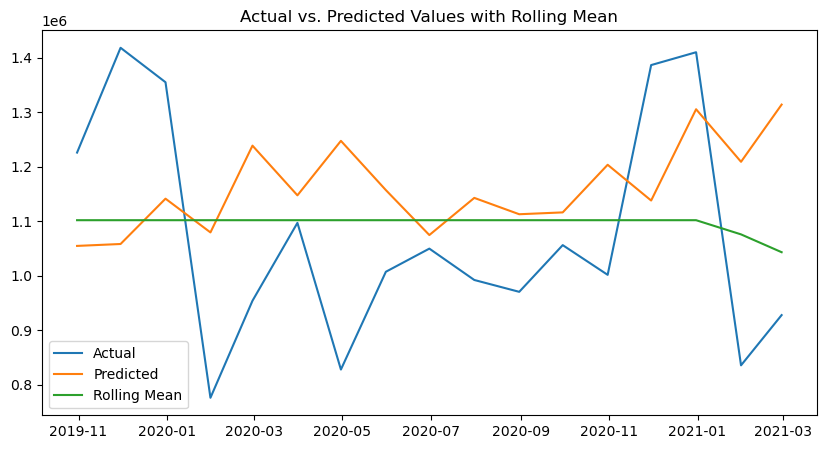

In [55]:
# Plot actual and predicted values
plt.figure(figsize=(10,5))
plt.plot(Test.index, Test['Quantity'], label='Actual')
plt.plot(Test.index, pred_hwe_rm, label='Predicted')
plt.plot(Test.index, rolling_mean, label='Rolling Mean')
plt.legend(loc='best')
plt.title('Actual vs. Predicted Values with Rolling Mean')
plt.show()

In [56]:
data = [('Auto Regression', mape_ar),  
        ('Simple Exponential Smoothing', mape_ses1),
        ('Holts winter exponential smoothing with additive seasonality and additive trend', mape_hwe_add_add), 
        ('Holts winter exponential smoothing with multiplicative seasonality and additive trend', mape_hwe_mul_add),
        ('Holts winter exponential smoothing with multiplicative seasonality, additive trend and rolling mean', mape_hwe_rm),
        ('ARIMA', mape_arm)]

mape = pd.DataFrame(data, columns=['Model Name', 'MAPE'])
mape.sort_values(by = 'Model Name', ascending = False, ignore_index = True)

,Model Name,MAPE
0,Simple Exponential Smoothing,29.92%
1,Holts winter exponential smoothing with multip...,7.435267
2,Holts winter exponential smoothing with multip...,24.89%
3,Holts winter exponential smoothing with additi...,22.42%
4,Auto Regression,14.35%
5,ARIMA,15.95%
